In [2]:
from methods import *
from hyperseed_v2 import *

In [3]:
DIC= dict(zip(range(1,11),range(0,10)))

In [4]:
d =2000

In [6]:
from mnist import MNIST
import numpy as np
mndata = MNIST("..\\Hyperseed\\Data\\MNIST\\")
np.random.seed(0)
imagesTrain, labelsTrain = mndata.load_training()

imagesTest, labelsTest = mndata.load_testing()
 
    
imagesTrain, labelsTrain = np.array(imagesTrain), np.array(labelsTrain)
imagesTest, labelsTest = np.array(imagesTest), np.array(labelsTest)
trainSize = 5000
testSize = 2000
trainImageSet,trainLabelSet = imagesTrain[:trainSize]/255,labelsTrain[:trainSize]
inferImageSet, inferLabelSet = imagesTest[:testSize]/255,labelsTest[:testSize]



trX,trY = trainImageSet,trainLabelSet
teX,teY = inferImageSet,inferLabelSet

X,y = trX[:],trY[:]
X_test,y_test = teX[:],teY[:]
bits = d




from sklearn import decomposition
pca = decomposition.PCA()
compSize=784
pca.n_components = compSize
model = pca.fit(X)#



import numpy as np

#### Random project data from 784 to dimension d

np.random.seed(4) ## 4
rnd_project =  2 * np.pi * np.random.rand(compSize, bits) # random angles
rnd_project = 1 * np.exp(1j * rnd_project).real # create a phasor vector


print(X.shape,rnd_project.shape)
TR_D = np.matmul(X,rnd_project)#X#np.matmul(X,rnd_project)
TR_D_test=np.matmul(X_test,rnd_project)#X_test#np.matmul(X_test,rnd_project)


d = bits

### Use fft to make the vectors complex

HD_X_shuffeled,y_shuffeled = np.fft.fft(TR_D),y
HD_X_shuffeled_test,y_shuffeled_test = np.fft.fft(TR_D_test),y_test



numClasses=10
num_classes=numClasses
classes = [[] for _ in range(numClasses)]
classes_test = [[] for _ in range(numClasses)]
for i in range(len(HD_X_shuffeled)):
    classes[int(y_shuffeled[i])].append(HD_X_shuffeled[i])
    
for i in range(len(HD_X_shuffeled_test)):
    classes_test[int(y_shuffeled_test[i])].append(HD_X_shuffeled_test[i])
    
    
samplesPerClass=[len(i) for i in classes]
samplesPerClassTest=[len(i) for i in classes_test]

selected_classes= range(10)#[0,1,2,3, 4]# range(10)# [0,1,2,3, 4]
TR_perm = np.concatenate(([classes[i] for i in selected_classes]), axis = 0)
TR_L_perm = np.concatenate(([[i+1]*samplesPerClass[i] for i in selected_classes]), axis = 0)

TE_perm = np.concatenate(([classes_test[i] for i in selected_classes]), axis = 0)
TE_L_perm = np.concatenate(([[i+1]*samplesPerClassTest[i] for i in selected_classes]), axis = 0)

(5000, 784) (784, 2000)


In [7]:
levels=20
nodes=100
sim_bases=0.001#15
sim_baseVSacc=[]
while(sim_bases<=0.1):
    np.random.seed(0)
    seed,bases,CodeBooks=HyperSeed_2(TR_perm,TR_L_perm,TE_perm,TE_L_perm,sim_bases,levels,nodes,d)
    trainData, trainLabels= [],[]
    samples=[]
    results=[]
    stats= np.zeros((levels,nodes))
    for i in range(len(TR_perm)):
        hd_new = TR_perm[i];
        Ibmu = seed * np.conj(hd_new);
        inds,work=findCoordinates(Ibmu,CodeBooks)
        for j in range(len(inds)):
            stats[j][int(inds[j])]+=1
        trainData.append(inds.astype('int'))
        samples.append(hd_new)
        results.append(inds.astype('int'))
        trainLabels.append(TR_L_perm[i])
    trainData= np.array(trainData).real

    testData, testLabels= [],[]
    for i in range(len(TE_perm)):
        hd_new = TE_perm[i];
        Ibmu = seed * np.conj(hd_new);
        inds,work=findCoordinates(Ibmu,CodeBooks)
        testData.append(inds.astype('int'))
        testLabels.append(TE_L_perm[i])
    testData=np.array(testData).real
    trainLabels=np.array(trainLabels)
    testLabels=np.array(testLabels)

    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import svm

    from xgboost import XGBClassifier


    model = KNeighborsClassifier(n_neighbors=3)# LogisticRegression(random_state=0)
    # model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    # LR_classifier.fit(trainData, trainLabels)
    model.fit(trainData, trainLabels-1)
    prediction = model.predict(testData)

    from sklearn.metrics import classification_report
    print(classification_report(testLabels-1, prediction))
    acc=np.round(classification_report(testLabels-1, prediction,output_dict=True)["accuracy"],3)
    sim_baseVSacc.append([sim_bases,acc])
    sim_bases+=0.005

SELECTED sample:  4977
SELECTED sample:  446
SELECTED sample:  1041
SELECTED sample:  449
SELECTED sample:  3662
SELECTED sample:  1196
SELECTED sample:  341
SELECTED sample:  679
SELECTED sample:  2340
SELECTED sample:  2555
SELECTED sample:  2128
SELECTED sample:  2956
SELECTED sample:  969
SELECTED sample:  2732
SELECTED sample:  3412
SELECTED sample:  2664
SELECTED sample:  3756
SELECTED sample:  930
SELECTED sample:  2628
SELECTED sample:  606
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       175
           1       0.81      0.96      0.88       234
           2       0.78      0.73      0.75       219
           3       0.57      0.67      0.61       207
           4       0.82      0.76      0.79       217
           5       0.60      0.51      0.55       179
           6       0.86      0.67      0.75       178
           7       0.82      0.78      0.80       205
           8       0.63      0.52      0.57       192
      

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})# stats

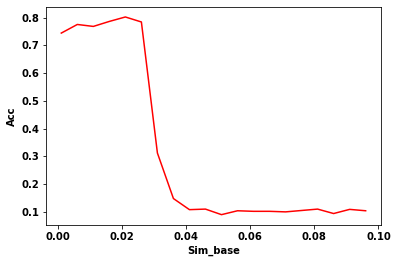

In [10]:
# data to be plotted
x = np.array(sim_baseVSacc)[:,0]
y = np.array(sim_baseVSacc)[:,1]

# plotting 
# plt.title("Sim_bases vs Acc")
plt.xlabel("Sim_base")
plt.ylabel("Acc")
plt.plot(x, y, color ="red")
plt.show()